In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u


data = pd.read_csv ("Allsupernovae.csv") #reading in supernovae data to create data frame 'data'

cosmo = FlatLambdaCDM(H0=70, Om0=0.287) #H0 value from Betoule et al. 2014, omega_m best fit value from JLA sample, 
                                        #cosmological model assuming flat Universe


#Calculating luminosity distances to supernovae
data['d_L'] = cosmo.luminosity_distance(data.zcmb) #changing cmb redshift to distance in Mpc

#Distance modulus eq 
#mu = 5log(d_L/10pc) or bmag-absmag = mu = 5 log10(D_L) + 25 if D_L is in Mpc
data['mu'] = 5*(np.log10(data.d_L)) + 25

#redshift values for cosmological fit
#can't use float in for loop so have to implement it before loop 
def frange(start, stop, step):
        i = start
        while i < stop:
            yield i
            i += step

redshift=[]
y=[]

for i in frange(0.01, 1, 0.01):
    dist = cosmo.luminosity_distance(i)
    dist *= pow(10,6) 
    dist = dist*(1./u.Mpc)
    mu_1 = 5*np.log10(dist/10)
    redshift.append((i))
    y.append((mu_1.value))
    
#errors
data['err_dm'] = data.error_mb + (0.01 + (0.117*data.error_X1)*(0.006*data.X1) + (2.450*data.error_c)*(0.070*data.c))

#distance modulus eq using best fit vals with no corrections
data['distance_modulus'] = data.mb - (-19.10 - 0.117*data.X1 + 2.450*data.c) 



In [9]:
#reduce data to only include star forming galaxies
reduced = data[(data['logsSFR'].notnull()) & (data['logsSFR'] > -10.5)]
#data[(data.LogMst > 7) & (data.LogMst < 10)] #low mass so it can also be tested


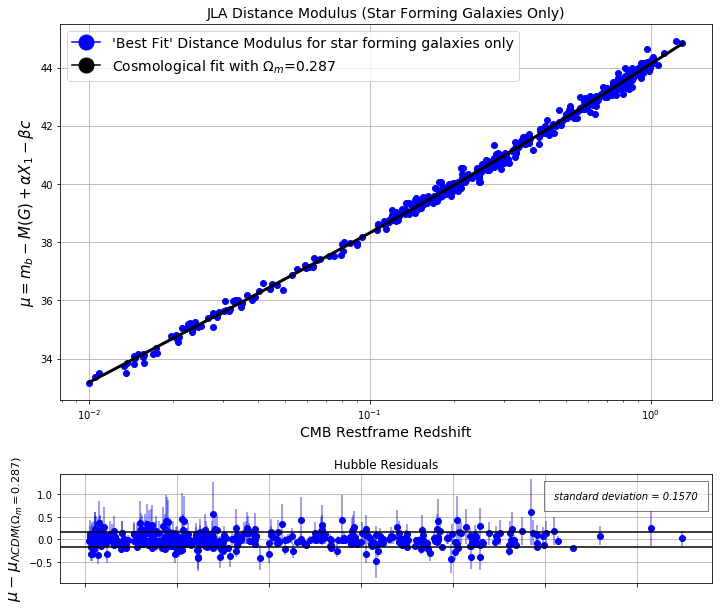

In [10]:
fig = plt.figure(figsize=(10,10)) 
plt.subplot2grid((60,1), (0,0), rowspan = 35)
plt.plot(reduced.zcmb, reduced.distance_modulus, 'o', color='blue')


#plotting luminosity distances for supernovae
plt.plot(np.sort(reduced.zcmb), np.sort(reduced.mu), linewidth=3, color='k')

#Making a legend
blue_line = mlines.Line2D([], [], color='blue', marker='o',markersize=15, 
            label='\'Best Fit\' Distance Modulus for star forming galaxies only')
black_line = mlines.Line2D([], [], color='k', marker='o',markersize=15, label='Cosmological fit with $\Omega_m$=0.287')
plt.legend(handles=[blue_line, black_line], fontsize=14)

#Title and axes
plt.title('JLA Distance Modulus (Star Forming Galaxies Only)', fontsize=14)
plt.xscale('log')
plt.xlabel('CMB Restframe Redshift', fontsize=14)
plt.ylabel(r'$\mu = m_{b} - M(G) + \alpha X_{1} - \beta c$', fontsize=15)
plt.grid(True)
plt.tight_layout()

#residuals
res_nostep = reduced.distance_modulus - reduced.mu

#std dev (numpy)
stat = np.std(res_nostep)


#residuals
low_error = res_nostep + reduced.err_dm
up_error = res_nostep + reduced.err_dm
asym_error = [low_error, up_error]


#plotting residual subplots
plt.subplot2grid((60,1),(37,0), rowspan = 13)
plt.plot(reduced.zcmb, res_nostep, 'bo')
plt.title('Hubble Residuals')
plt.text(1.02, 0.9, 'standard deviation = 0.1570', style='italic', bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
plt.tick_params(labelbottom='off')
plt.ylabel(r'$\mu - \mu_{\Lambda CDM (\Omega_m = 0.287)}$', fontsize=16)
plt.errorbar(reduced.zcmb, res_nostep, fmt='none', yerr=asym_error, color='blue', alpha=0.5)
plt.axhline(y=stat, color='k')
plt.axhline(y=(-stat), color='k')
plt.grid(True)



plt.show()

fig.savefig('Star Forming Galaxies Only.pdf')
plt.close(fig)

In [23]:
print(stat)   #numpy std dev (active gal. supernovae)

0.15698937026286153


In [13]:
print(best_vals)
print(np.sqrt(np.diag(cov)))

[-19.09564235   0.10621271   2.46329753]
[ 0.00802994  0.00876967  0.09278367]
